# Analyse fitted concentrations

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
import torch
from math import ceil
sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [2]:
import re
from pathlib import Path
from datetime import datetime
from plot_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- inputs ---
PARAM_DIR = Path("../params_by_period_0.03_m1_m8_m7")  # folder containing param_period_*.csv
ab_class_df = pd.read_csv("../exp_data/ab_classification.csv")
# ab_class_df columns: ['condition', 'condition_subtype']

# --- helpers ---
def _extract_period_label(p: Path) -> str:
    """
    From filename like 'param_period_2021-01-01.csv' -> '2021-01-01'.
    If your label format differs, adjust the regex.
    """
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p.name)
    if not m:
        # try YYYY-MM
        m2 = re.search(r"param_period_([0-9]{4}-[0-9]{2})\.csv$", p.name)
        if not m2:
            raise ValueError(f"Cannot parse period label from {p.name}")
        return m2.group(1) + "-01"
    return m.group(1)

def _period_to_datetime(label: str) -> pd.Timestamp:
    # label like 'YYYY-MM-DD'
    return pd.to_datetime(label, format="%Y-%m-%d", errors="coerce")

# --- load all params and build long df ---
rows = []
for csv_path in sorted(PARAM_DIR.glob("param_period_*.csv")):
    period_label = _extract_period_label(csv_path)          # 'YYYY-MM-DD'
    period_dt = _period_to_datetime(period_label)

    df = pd.read_csv(csv_path)
    if df.empty:
        continue
    row0 = df.iloc[0]

    beta_rbm = float(np.exp(row0["raw_beta"]))
    ace2 = float(row0["raw_ace2"])

    # any column that starts with 'raw_c_' is an antibody
    ab_cols = [c for c in df.columns if c.startswith("raw_c_")]
    for c in ab_cols:
        ab_name = c.removeprefix("raw_c_")
        conc = float(row0[c])
        #put between -12 and -5
        if conc < -12:
            conc = -12
        if conc > -5:
            conc = -5
        rows.append(
            {
                "time_period": period_dt,
                "beta_rbm": beta_rbm,
                "ACE2": ace2,
                "ab_names": ab_name,
                "conc": conc,
            }
        )

df_conc = pd.DataFrame(rows)
df_conc = df_conc.sort_values("time_period").reset_index(drop=True)

# --- join with classification to get class per antibody ---
# ab_class_df: condition=ab name, condition_subtype = antibody class (e.g., 'class 1')
ab_class_df = ab_class_df.rename(columns={"condition": "ab_names"})
df_merged = df_conc.merge(ab_class_df[["ab_names", "condition_subtype"]],
                          on="ab_names", how="left")

# Optional: warn on antibodies missing a class
missing = df_merged["condition_subtype"].isna().sum()
if missing:
    print(f"[warn] {missing} entries have no class in ab_class_df (left as NaN).")

# --- 1) Plot class mean conc vs time ---
class_mean = (
    df_merged.groupby(["time_period", "condition_subtype"], dropna=False)["conc"]
    .mean()
    .reset_index()
)

# Pivot for multi-line plot
pivot_class = class_mean.pivot(index="time_period", columns="condition_subtype", values="conc")
pivot_class = pivot_class.sort_index()

ace2_per_period = (
    df_conc.drop_duplicates(["time_period"])[["time_period", "ACE2"]]
    .sort_values("time_period")
)
beta_per_period = (
    df_conc.drop_duplicates(["time_period"])[["time_period", "beta_rbm"]]
    .sort_values("time_period")
)



# --- optional: save df_conc for downstream use ---
# df_conc.to_csv("df_conc.csv", index=False)


C:\Users\maria\AppData\Local\Temp\ipykernel_18244\3295292638.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


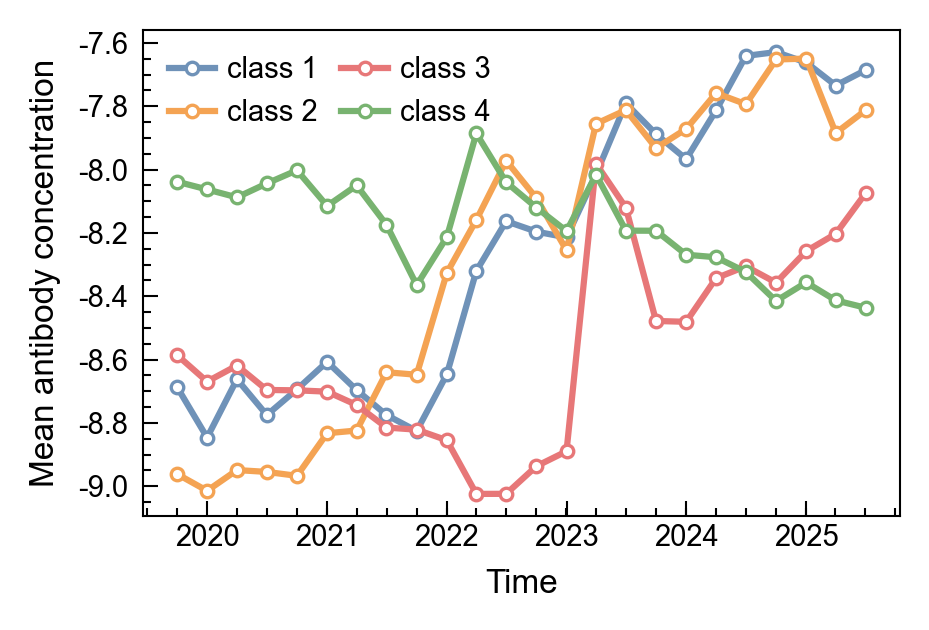

In [3]:
nature_rc()
colors = get_lightened_cycle(len(pivot_class.columns), amount=0.01)
#colors = get_lightened_cycle(len(pivot_class.columns), amount=0.35) --- IGNORE ---
fig = plt.figure(figsize=(3.2, 2.2))
ax = plt.gca()

for i, col in enumerate(pivot_class.columns):
    ax.plot(
        pivot_class.index, pivot_class[col].values,
        label=str(col),
        color=colors[i],
        marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
    )

ax.set_xlabel("Time")
ax.set_ylabel("Mean antibody concentration")
ax.legend(loc="best", ncol=2, handletextpad=0.4, columnspacing=0.8)
# ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
# ax.tick_params(which="minor", bottom=False, top=False, left=False, right=False)

apply_yearly_date_axis(ax)
fig.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_18244\986695273.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


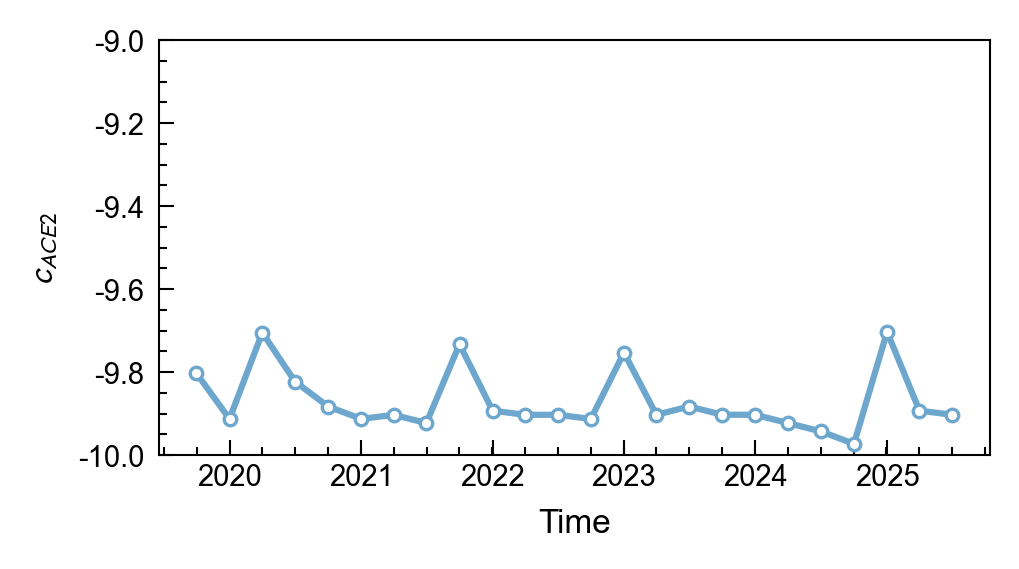

In [16]:
nature_rc()
fig = plt.figure(figsize=(3.5, 2.0)); ax = plt.gca()
ax.plot(
    ace2_per_period["time_period"], ace2_per_period["ACE2"],
    color=lighten_color("#1f77b4", 0.35), marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
)
ax.set_xlabel("Time"); ax.set_ylabel(r"$c_{ACE2}$")
ax.set_ylim(-10, -9)

# ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
apply_yearly_date_axis(ax)
fig.tight_layout()
#
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_27588\1826194821.py:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


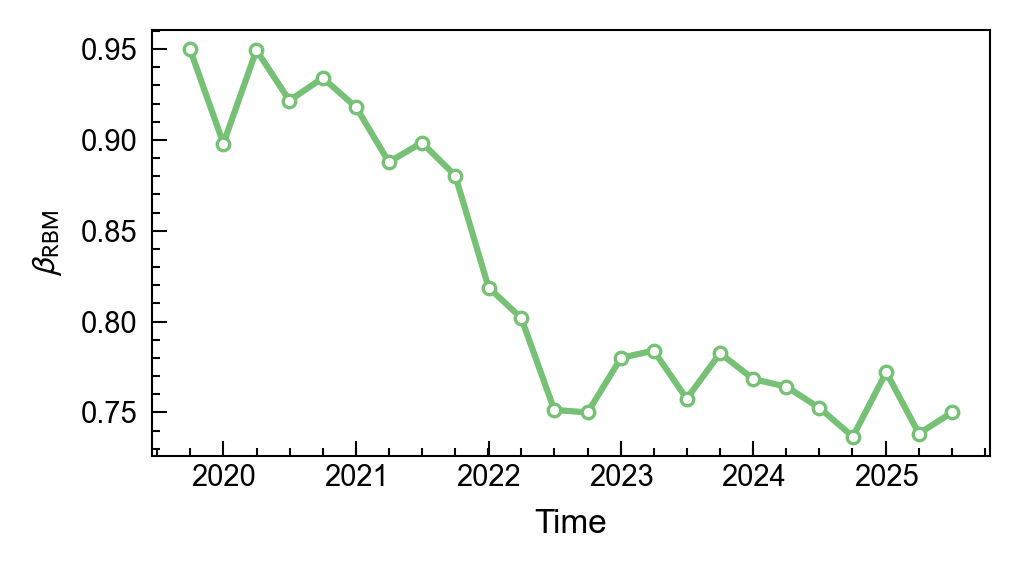

In [ ]:
nature_rc()
fig = plt.figure(figsize=(3.5, 2.0)); ax = plt.gca()
ax.plot(
    beta_per_period["time_period"], beta_per_period["beta_rbm"],
    color=lighten_color("#2ca02c", 0.35), marker="o", lw=1.5, ms=3, mfc="white", mew=0.8
)
ax.set_xlabel("Time"); ax.set_ylabel(r"$\beta_{\mathrm{RBM}}$")
# ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
apply_yearly_date_axis(ax)
fig.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_27588\805391098.py:125: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


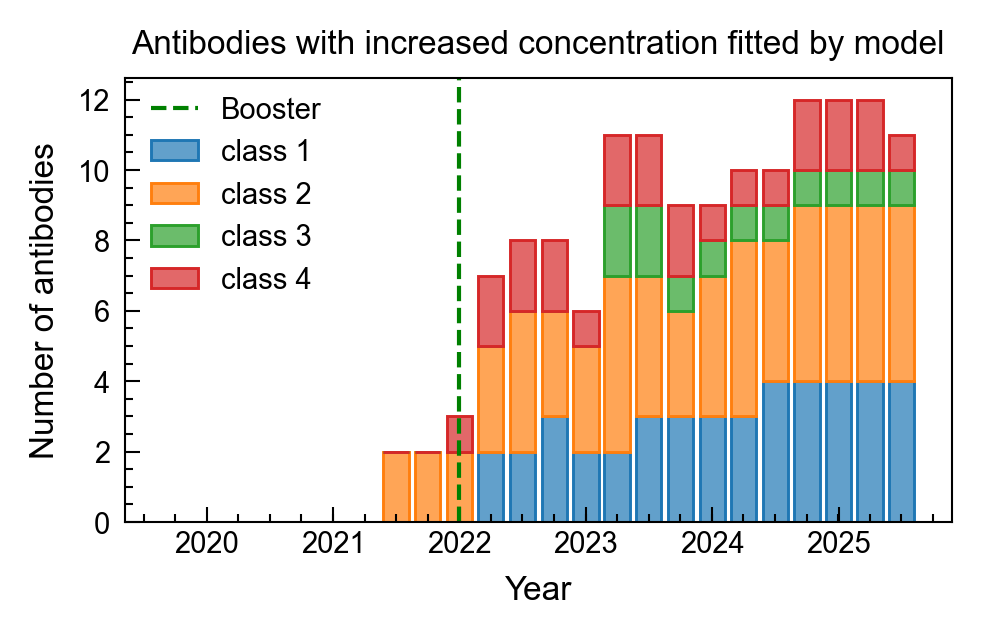

In [ ]:
# --- 2) Count "increased vs first period" per class and plot stacked bars ---

# 2.1 Baseline per antibody = its first observed period's concentration
first_obs = (
    df_merged.sort_values(["ab_names", "time_period"])
             .groupby("ab_names", as_index=False)
             .first()[["ab_names", "conc"]]
             .rename(columns={"conc": "baseline_conc"})
)

dfb = (
    df_merged.merge(first_obs, on="ab_names", how="left")
             .assign(condition_subtype=lambda d: d["condition_subtype"].fillna("Unclassified"))
)

# "Increase" means numerically larger log10 concentration (closer to -5), i.e., conc > baseline
dfb["increased"] = dfb["conc"] > dfb["baseline_conc"]+np.log(2)

# 2.2 Count increases per class, per period
inc_counts = (
    dfb.groupby(["time_period", "condition_subtype"], dropna=False)["increased"]
       .sum()
       .reset_index(name="n_increased")
)

# Pivot for stacked bars
pivot_inc = (
    inc_counts.pivot(index="time_period", columns="condition_subtype", values="n_increased")
              .fillna(0)
              .astype(int)
              .sort_index()
)

# 2.3 Order classes nicely: class 1..4 first (if present), then others alphabetically
def _order_classes(cols):
    import re as _re
    def _key(c):
        m = _re.search(r"(\d+)", str(c))
        return (0, int(m.group(1))) if m else (1, str(c).lower())
    return sorted(cols, key=_key)

class_order = _order_classes(list(pivot_inc.columns))
# --- Nature-ready stacked bar: antibodies increased vs first period, by class ---
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import to_rgb

# 0) Apply your Nature rcParams
nature_rc()

# 1) Order classes: class 1..4 first, then others alphabetically
import re as _re
def _order_classes(cols):
    def _key(c):
        s = str(c)
        m = _re.search(r"(\d+)", s)
        return (0, int(m.group(1))) if m else (1, s.lower())
    return sorted(cols, key=_key)

# Make sure pivot_inc exists (built from your previous step)
pivot_inc = (
    inc_counts.pivot(index="time_period", columns="condition_subtype", values="n_increased")
              .fillna(0)
              .astype(int)
              .sort_index()
)

class_order = _order_classes(list(pivot_inc.columns))

# 2) Palette: base class colors, lightened faces + darker edges
CLASS_COLORS = {
    "class 1": "#1f77b4",
    "class 2": "#ff7f0e",
    "class 3": "#2ca02c",
    "class 4": "#d62728",
    "Unclassified": "#7f7f7f",
}
# Fallback colors (already lightened by helper)
fallback_cycle = get_lightened_cycle(len(class_order), amount=0.25)
_fallback_iter = iter(fallback_cycle)

def _base_color(cls):
    for k, v in CLASS_COLORS.items():
        if str(cls).lower() == k.lower():
            return v
    return next(_fallback_iter)

def _face_edge(cls, lighten_amt=0.35):
    base = _base_color(cls)
    face = lighten_color(base, amount=lighten_amt)
    edge = base
    return face, edge

# 3) Build bars
xdates = pivot_inc.index
x = mdates.date2num(xdates.to_pydatetime())
width_days = (0.8 * np.median(np.diff(x))) if len(x) > 1 else 28.0

fig, ax = plt.subplots(figsize=(3.35, 2.2))  # ~85 mm × 56 mm (Nature single-column)

bottom = np.zeros(len(x), dtype=float)
for cls in class_order:
    y = pivot_inc[cls].to_numpy()
    face, edge = _face_edge(cls, lighten_amt=0.30)
    ax.bar(
        x, y, bottom=bottom, width=width_days, align="center",
        color=face, edgecolor=edge, linewidth=0.7, label=str(cls)
    )
    bottom += y

# 4) Axes, ticks, legend
apply_yearly_date_axis(ax)
ax.set_ylabel("Number of antibodies")
ax.set_xlabel("Year")
#title
ax.set_title("Antibodies with increased concentration fitted by model", pad=6)
#add green vertical line end 2021 for booster
ax.axvline(x=mdates.date2num(datetime(2021,12,31)), color='green', linestyle='--', lw=1, label='Booster')



# Compact legend; move slightly above plot if many classes
ax.legend( ncol=1, loc="upper left", bbox_to_anchor=(0.0, 1.02))

plt.tight_layout(pad=1.0)
plt.show()


In [ ]:
pandemic_seqs=Proteins_utils.load_FASTA("../seq_data/ns_mutated_spike.fasta")
logkd_mat = np.vstack([get_Kd(seq, KD_VECTORS, log10=True) for seq in pandemic_seqs])  # shape: (N_filtered, n_abs)
logkd_mat.shape#Nseq * n_abs

(3704, 29)

C:\Users\maria\AppData\Local\Temp\ipykernel_27588\1204086402.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.9)


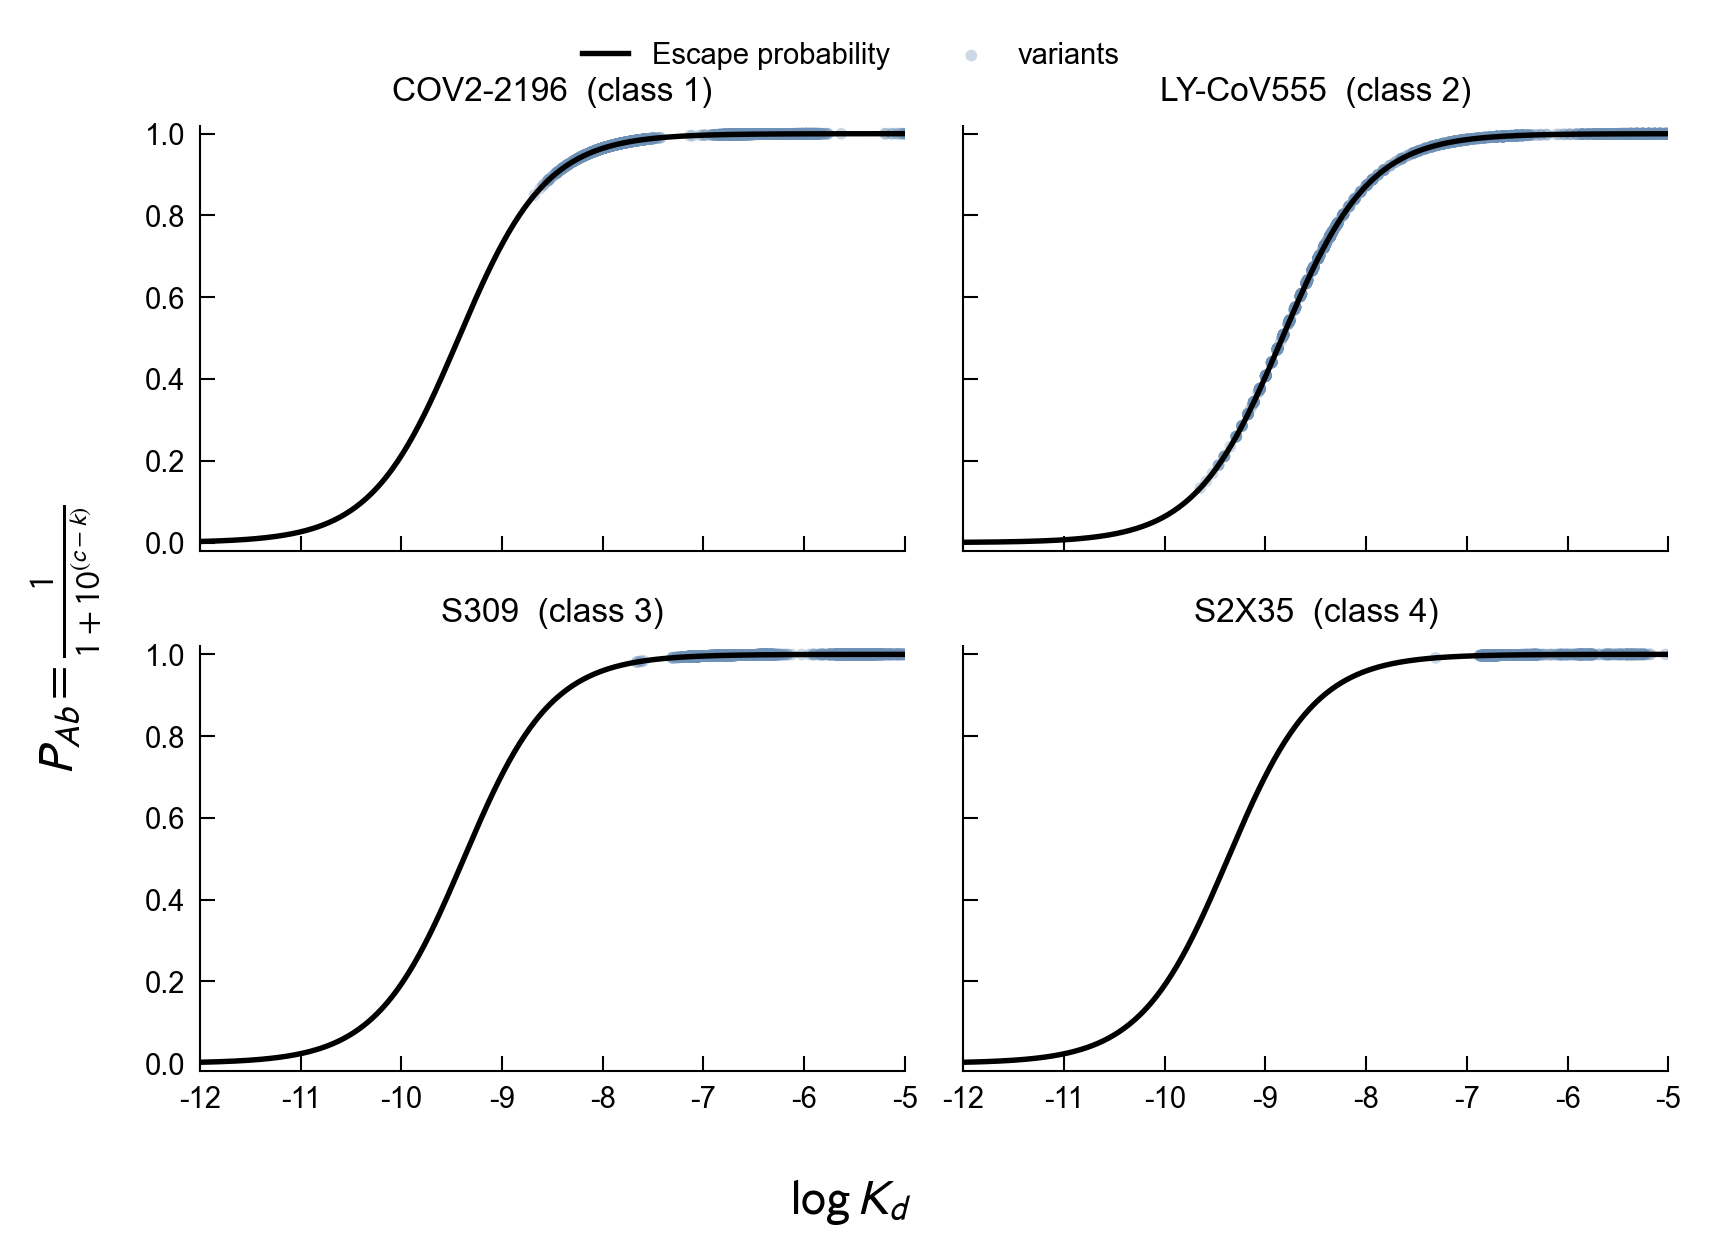

In [ ]:
# --- One subplot per antibody; overlay variant points from pandemic_seqs logKd ---
my_abs = pd.Series({
    1: 'COV2-2196',
    2: "LY-CoV555",
    3: "S309",
    4: "S2X35",
})
# Make sure ab_names follows KD_VECTORS order
ab_names = list(KD_VECTORS.keys())
ab_to_idx = {name: i for i, name in enumerate(ab_names)}

# First period c-values (already clipped to [-12, -5] in df_conc creation)
first_period = df_conc["time_period"]
#ADD 6 months
first_period = df_conc["time_period"].min() + pd.DateOffset(months=12)

c_first = (df_conc[df_conc["time_period"] == first_period]
           .set_index("ab_names")["conc"])

# Your 4 antibodies: use my_abs if you defined it; otherwise pick 4 present
try:
    selected_abs = [a for a in my_abs if a in c_first.index and a in ab_to_idx][:4]
except NameError:
    present = [a for a in c_first.index if a in ab_to_idx]
    selected_abs = present[:4]

if len(selected_abs) < 1:
    raise RuntimeError("No overlapping antibodies between df_conc first-period and KD_VECTORS.")

# kd grid
kd_grid = np.linspace(-12, -5, 400)

# Nature rc
nature_rc()

# Figure
fig, axes = plt.subplots(2, 2, figsize=(5.7, 4.), sharex=True, sharey=True)  # 2 columns wide
axes = axes.ravel()

for ax, ab in zip(axes, selected_abs):
    c_val = float(c_first.loc[ab])
    c_val = float(np.clip(c_val, -12.0, -5.0))

    # Curve: y = 1/(1 + 10^(c - kd))
    y_curve = 1.0 / (1.0 + np.power(10.0, (c_val - kd_grid)))
    ax.plot(kd_grid, y_curve, lw=1.3, color="k", label="Escape probability")

    # Points from pandemic_seqs for this Ab
    j = ab_to_idx[ab]
    v_logkd = logkd_mat[:, j]
    v_logkd = v_logkd[np.isfinite(v_logkd)]
    y_pts = 1.0 / (1.0 + np.power(10.0, (c_val - v_logkd)))
    ax.scatter(v_logkd, y_pts, s=8, alpha=0.35, edgecolors="none", label="variants")

    # Styling
    # build once (you already renamed 'condition' -> 'ab_names' above)
    ab_class_map = ab_class_df.set_index("ab_names")["condition_subtype"].to_dict()

    # ... inside your plotting loop ...
    cls = ab_class_map.get(ab, "Unclassified")
    ax.set_title(f"{ab}  ({cls})", fontsize=8)
# or, if you want to keep c/date too:
# ax.set_title(f"{ab}  ({cls})   c={c_val:.2f}, {first_period:%Y-%m-%d}", fontsize=8)

    ax.set_xlim(-12, -5)
    ax.set_ylim(-0.02, 1.02)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="in", top=False, right=False)

# Turn off unused panels if < 4 selected
for ax in axes[len(selected_abs):]:
    ax.axis("off")

# Labels and shared legend
fig.supxlabel(r"$\log K_d$")
fig.supylabel(r"$P_{Ab}=\frac{1}{1+10^{(c-k)}}$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(pad=0.9)
plt.show()


In [ ]:
ab_class_map

{'COV2-2196': 'class 1',
 'COV2-2130': 'class 3',
 'COV2-2955': 'class 2',
 'CR3022': 'class 4',
 'COV2-2677': 'class 4',
 'COV2-2082': 'class 4',
 'COV2-2094': 'class 4',
 'COV2-2165': 'class 1',
 'COV2-2832': 'class 1',
 'COV2-2479': 'class 2',
 'COV2-2050': 'class 2',
 'COV2-2096': 'class 2',
 'COV2-2499': 'class 3',
 'C002': 'class 2',
 'C105': 'class 1',
 'C110': 'class 3',
 'C121': 'class 2',
 'C135': 'class 3',
 'C144': 'class 2',
 'LY-CoV555': 'class 2',
 'REGN10933': 'class 1',
 'REGN10987': 'class 3',
 'LY-CoV016': 'class 1',
 'S309': 'class 3',
 'S2H97': 'class 4',
 'S304': 'class 4',
 'S2X35': 'class 4',
 'S2E12': 'class 1',
 'S2X16': 'class 2',
 'S2H58': 'class 2',
 'S2H13': 'class 2',
 'S2D106': 'class 2',
 'S2X58': 'class 2',
 'S2H14': 'class 1',
 'S2X227': 'class 3',
 'S2X259': 'class 4'}